In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os

In [2]:
# Paso de latitud/longitud a coordenadas x, y en la proy. Mercator (en km)
def merc_from_arrays(lats, lons):
    r_major = 6378.137000
    x = r_major * np.radians(lons)
    scale = x/lons
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + lats * (np.pi/180.0)/2.0)) * scale
    return np.vstack((x, y)).T

In [13]:
coords = pd.read_csv('coordinate-countries-fixed.csv')
coords = coords.rename(columns={'ISO 3166 Country Code': 'Code'})
coordinates = merc_from_arrays(coords['Latitude'], coords['Longitude'])
coords['x'] = coordinates[:, 0]
coords['y'] = coordinates[:, 1]
coords

,Code,Country,Latitude,Longitude,x,y
0,AD,Andorra,42.50,1.50,166.979236,5236.173784
1,AE,United Arab Emirates,24.00,54.00,6011.252503,2753.408109
2,AF,Afghanistan,33.00,65.00,7235.766902,3895.303963
3,AG,Antigua and Barbuda,17.05,-61.80,-6879.544531,1926.646111
4,AI,Anguilla,18.25,-63.17,-7032.052233,2066.831460
...,...,...,...,...,...,...
234,YE,Yemen,15.00,48.00,5343.335558,1689.200140
235,YT,Mayotte,-12.83,45.17,5028.301399,-1440.316792
236,ZA,South Africa,-29.00,24.00,2671.667779,-3375.646035
237,ZM,Zambia,-15.00,30.00,3339.584724,-1689.200140


In [21]:
nodes = pd.read_csv('nodes-fixed.csv')
nodes = nodes.rename(columns={'# index': 'index', ' name': 'name'})
nodes = nodes.drop(columns=[' nodeLabel', ' _pos'])
# Reemplazo '_' con ' ' para que matcheen mas paises
nodes['name'] = nodes['name'].str.replace('_', ' ')

# Merge DataFrames A and B based on matching country names
merged_nodes = pd.merge(coords, nodes, left_on='Country', right_on='name')

# Filter and sort the merged DataFrame
merged_nodes = merged_nodes[['index', 'Country', 'Code', 'Latitude', 'Longitude', 'x', 'y']].sort_values(by='index')
merged_nodes.reset_index(drop=True, inplace=True)
merged_nodes

,index,Country,Code,Latitude,Longitude,x,y
0,0,Afghanistan,AF,33.00,65.00,7235.766902,3895.303963
1,1,Australia,AU,-27.00,133.00,14805.492276,-3123.471749
2,2,Austria,AT,47.33,13.33,1483.888812,5996.105804
3,3,Belgium,BE,50.83,4.00,445.277963,6591.277603
4,4,Brazil,BR,-10.00,-55.00,-6122.571994,-1118.889975
...,...,...,...,...,...,...,...
203,209,Cayman Islands,KY,19.50,-80.50,-8961.219009,2213.892183
204,210,Mayotte,YT,-12.83,45.17,5028.301399,-1440.316792
205,211,Maldives,MV,3.25,73.00,8126.322828,361.982512
206,212,Mauritania,MR,20.00,-12.00,-1335.833890,2273.030927


In [27]:
layer = 1
all_edges = pd.read_csv('edges.csv')
all_edges = all_edges.rename(columns={'# source': 'source', ' target': 'target', ' weight': 'weight', ' layer': 'layer'})

unique_count = all_edges[['source', 'target']].values.flatten()
unique_count = len(set(unique_count))

print("All layers unique count:", unique_count)
# Filtro solo un layer
one_layer_edges = all_edges[all_edges['layer'] == layer]
# Saco cuando source = target (que onda esto?)
one_layer_edges = one_layer_edges[one_layer_edges['source'] != one_layer_edges['target']]
# Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

unique_count = one_layer_edges[['source', 'target']].values.flatten()
unique_count = len(set(unique_count))

print(f"Layer {layer} unique count (already merged):", unique_count)


All layers unique count: 214
Layer 1 unique count (already merged): 174


In [47]:
def get_data(layer=1):
    coords = pd.read_csv('coordinate-countries-fixed.csv')
    coords = coords.rename(columns={'ISO 3166 Country Code': 'Code'})
    coordinates = merc_from_arrays(coords['Latitude'], coords['Longitude'])
    coords['x'] = coordinates[:, 0]
    coords['y'] = coordinates[:, 1]

    nodes = pd.read_csv('nodes-fixed.csv')
    nodes = nodes.rename(columns={'# index': 'index', ' name': 'name'})
    nodes = nodes.drop(columns=[' nodeLabel', ' _pos'])
    # Reemplazo '_' con ' ' para que matcheen mas paises
    nodes['name'] = nodes['name'].str.replace('_', ' ')

    # Merge DataFrames A and B based on matching country names
    merged_nodes = pd.merge(coords, nodes, left_on='Country', right_on='name')

    # Filter and sort the merged DataFrame
    merged_nodes = merged_nodes[['index', 'Country', 'Code', 'Latitude', 'Longitude', 'x', 'y']].sort_values(by='index')
    merged_nodes.reset_index(drop=True, inplace=True)


    all_edges = pd.read_csv('edges.csv')
    all_edges = all_edges.rename(columns={'# source': 'source', ' target': 'target', ' weight': 'weight', ' layer': 'layer'})

    unique_count = all_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    print("All layers unique count:", unique_count)
    # Filtro solo un layer
    one_layer_edges = all_edges[all_edges['layer'] == layer]
    # Saco cuando source = target (que onda esto?)
    one_layer_edges = one_layer_edges[one_layer_edges['source'] != one_layer_edges['target']]
    # Filtro los paises que no estan en el dataframe (los que no tienen coordenadas)
    one_layer_edges = one_layer_edges[one_layer_edges['source'].isin(merged_nodes['index']) & one_layer_edges['target'].isin(merged_nodes['index'])]

    unique_count = one_layer_edges[['source', 'target']].values.flatten()
    unique_count = len(set(unique_count))

    print(f"Layer {layer} unique count (already merged):", unique_count)

    filtered_nodes = merged_nodes[merged_nodes['index'].isin(one_layer_edges['source']) | merged_nodes['index'].isin(one_layer_edges['target'])]
    G = nx.from_pandas_edgelist(one_layer_edges, source= 'source', target = 'target')

    pos = {node : [filtered_nodes.loc[filtered_nodes['index'] == node, 'x'].values[0], filtered_nodes.loc[filtered_nodes['index'] == node, 'y'].values[0]] for node in filtered_nodes['index']}
    
    
    nx.set_node_attributes(G, pos, 'pos')
    nx.set_node_attributes(G, codes, 'code')

    return G, pos, filtered_nodes

In [48]:
G, pos, filtered_nodes = get_data(1)

All layers unique count: 214
Layer 1 unique count (already merged): 174


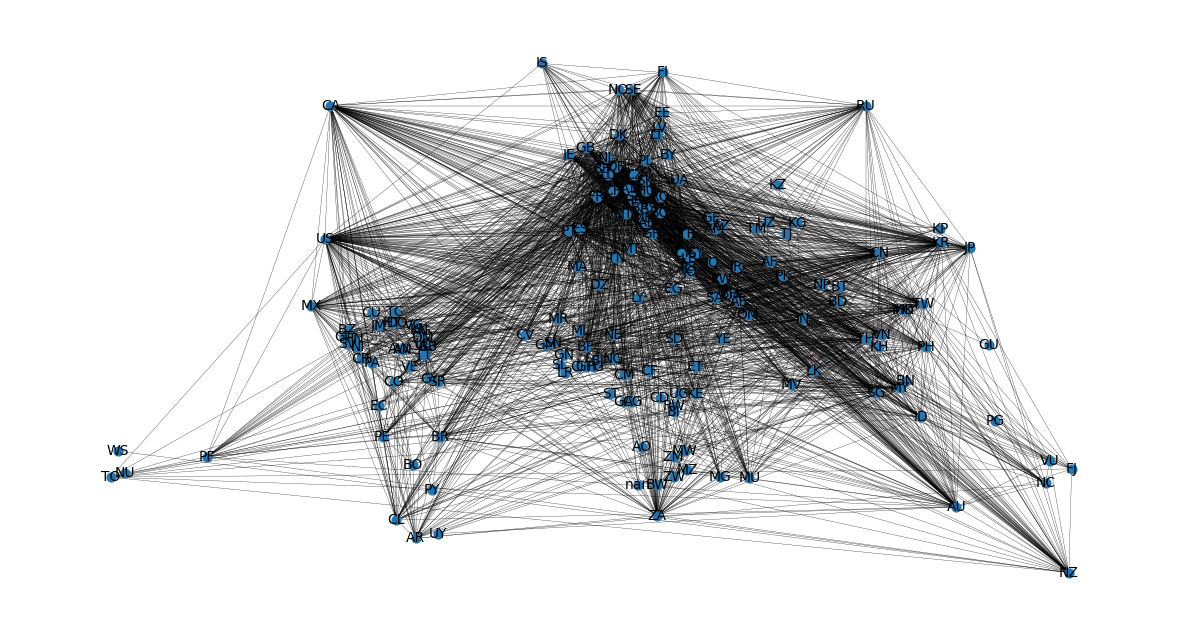

In [56]:
codes = {node : filtered_nodes.loc[filtered_nodes['index'] == node, 'Code'].values[0] for node in filtered_nodes['index']}

fig, ax = plt.subplots(figsize=(15,8))
nx.draw_networkx_labels(G, pos, codes, font_size=10)
nx.draw(G, pos=pos, node_size=40, width=.2, ax=ax)
# for i, txt in enumerate(filtered_nodes['Code']):
    # ax.annotate(txt, (filtered_nodes['x'][i], filtered_nodes['y'][i]), fontsize=8)